CSCI-635 Project 2
Group 10
Yelp data set utilzing BERT-base model and curriculum learning
Authors: Hunter Myer, Takeru Shimizu, Harshvardhan Singh, Shattek Tuerxunbaike
Emails: hem4262@rit.edu, ts8384@rit.edu, hs8154@rit.edu, xt3750@rit.edu






If error occurs, follow the instructions above the very last cell in this notebook

Below Cell that imports all external librarys and modules as well as install needed librarys

TextStat Citation - “Textstat.” PyPI, pypi.org/project/textstat/. Accessed 28 Mar. 2025.


##### **In order to run this colab in reasonable time, you must connect to GPU runtime. Additionary, training and testing on 1GB dataset might use up all the computatuoanl resource for free version, so you might need to comment out the larger models**

In [ ]:
!pip install transformers     # Install  Transformers library for pre-trained language models
!pip install textstat         # Install textstat for text readability and complexity metrics

import os                     # For interacting with the operating system (e.g., file paths)
import pandas as pd           # For data manipulation using DataFrames
import json                   # For parsing and creating JSON files
import re                     # For working with regular expressions
import string                 # For common string operations and constants
import torch                  # PyTorch deep learning framework
from transformers import BertForSequenceClassification, BertTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, get_scheduler  # tools for BERT and training
from torch.optim import AdamW              # Optimizer for training transformer models
from torch.amp import autocast, GradScaler # Tools for automatic mixed precision training
from torch.utils.data import DataLoader, Dataset  # PyTorch utilities for dataset and batching
from torch.nn import CrossEntropyLoss      # Loss function for classification tasks
import time                                # For measuring execution time
import textstat                            # External library for text statistics
import numpy as np                         # For numerical operations and array manipulation
import seaborn as sns                      # For data visualization
import matplotlib.pyplot as plt            # Plotting library for visualizations
from tqdm import tqdm                      # Progress bar for loops
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, ConfusionMatrixDisplay  # Evaluation metrics for models
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF for text feature extraction
from sklearn.linear_model import LogisticRegression           # Logistic regression model
import joblib                              # For saving and loading models
from collections import Counter            # For counting elements in collections

Below Cell that loads in the dataset from a saved google drive folder

In [ ]:
# Google drive information
file_id = "1IcL4QKcM7aWq8eohLdZhzMHBTjT7tSpx"  # Define the Google Drive File ID
zip_file = "yelp_academic_dataset_review.zip"  # Name of the zip file to download
data_file = "yelp_academic_dataset_review.json"  # Name of the JSON data file to extract

# Download the dataset if it's not already downloaded
if not os.path.exists(zip_file):
    print(" Downloading dataset from Google Drive...")
    !gdown --id {file_id} -O {zip_file}  # Download the dataset using gdown
else:
    print(" Dataset ZIP already downloaded")  # Skip download if file exists

# Extract the dataset if it's not already extracted
if not os.path.exists(data_file):
    print(" Extracting dataset...")
    !unzip -o {zip_file} -d "/content/"  # Extract ZIP to content directory
else:
    print(" Dataset already extracted")  # Skip extraction if file exists

# Verify JSON File Size
if os.path.exists(data_file):
    file_size_gb = os.path.getsize(data_file) / (1024 * 1024 * 1024)  # Get size in GB
    print(f" JSON File Size: {file_size_gb:.2f} GB")  # Display file size
else:
    print(" ERROR: JSON file is missing after extraction.")  # Error if not found

 Dataset ZIP already downloaded
 Dataset already extracted
 JSON File Size: 4.98 GB


Below Cell that handles preprocessing of data as well as saving it to a local file for easy use

In [ ]:
reviews = []  # List to store review entries
max_reviews = 2150000  # Limit to approx. 1.3 GB worth of reviews

"""
Hyper parameters for preprocessing and cleaning of data
"""
lower_case = False  # Set to True to lowercase all words
remove_punctuation = False  # Set to True to remove all punctuation

def preprocess_text(text):
    """
    Parameters:
        text: str - Input text to preprocess.

    Function that applies preprocessing steps such as lowercasing and
    punctuation removal based on defined hyperparameters.

    Returns:
        text: str - Cleaned/preprocessed text.
    """
    if lower_case:
        text = text.lower()  # Convert to lowercase
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Read JSONL (line by line) to prevent JSONDecodeError
with open(data_file, 'r') as f:
    for i, line in enumerate(f):
        try:
            review = json.loads(line.strip())  # Read and decode one line at a time
            review['text'] = preprocess_text(review.get('text', ''))  # Clean the review text
            reviews.append(review)  # Add to list
        except json.JSONDecodeError as e:
            print(f" ERROR decoding JSON on line {i}: {e}")  # Log the error with line number
            continue  # Skip bad lines

        if i >= max_reviews - 1:
            break  # Stop once reach the max number of reviews

df = pd.DataFrame(reviews)  # Convert to DataFrame
df.to_csv("subset_yelp_reviews.csv", index=False)  # Save to CSV without index

print(f" Saved {len(df)} reviews to CSV successfully!")  # Confirmation message

file_path = "subset_yelp_reviews.csv"  # Define file path

# Get file size in bytes and convert to MB/GB
file_size = os.path.getsize(file_path)  # Size in bytes
file_size_mb = file_size / (1024 * 1024)  # Convert to MB
file_size_gb = file_size / (1024 * 1024 * 1024)  # Convert to GB

print(f"File Size: {file_size_mb:.2f} MB ({file_size_gb:.2f} GB)")  # Print file size

df = pd.read_csv("subset_yelp_reviews.csv")  # Load CSV into DataFrame

total_rows = len(df)  # Get the number of rows

print(f"Total number of lines (reviews) in the {file_size_gb:.2f} dataset: {total_rows}")  # Print total number of reviews


 Saved 2150000 reviews to CSV successfully!
File Size: 1373.09 MB (1.34 GB)
Total number of lines (reviews) in the 1.34 dataset: 2150000


Confirm data frame is correct

In [ ]:
print(df.head(10))   # prints the first 10 lines of data frame to confirm correct informaiton

                review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   
5  JrIxlS1TzJ-iCu79ul40cQ  eUta8W_HdHMXPzLBBZhL1A  04UD14gamNjLY0IDYVhHJg   
6  6AxgBCNX_PNTOxmbRSwcKQ  r3zeYsv1XFBRA4dJpL78cw  gmjsEdUsKpj9Xxu6pdjH0g   
7  _ZeMknuYdlQcUqng_Im3yg  yfFzsLmaWF2d4Sr0UNbBgg  LHSTtnW3YHCeUkRDGyJOyw   
8  ZKvDG2sBvHVdF5oBNUOpAQ  wSTuiTk-sKNdcFyprzZAjg  B5XSoSG3SfvQGtKEGQ1tSQ   
9  pUycOfUwM8vqX7KjRRhUEA  59MxRhNVhU9MYndMkz0wtw  gebiRewfieSdtt17PTW6Zg   

   stars  useful  funny  cool  \
0    3.0       0      0     0   
1    5.0       1      0     1   
2    3.0       0      0     0   
3    5.0       1    

Below Cell Splits the data into the respective sample sizes. Saves each data set size to its own file as well as creates the dataframes to use. Datasets may vary a little in size based on data contained in them. Generally around the requried size as best as it can be.

In [ ]:
df_useful = df[['stars', 'text']]  # Keep only the 'stars' and 'text' columns for processing

# Save a small sample to estimate row size
sample_size = 10000  # Sample size for estimating average row size
df_sample = df_useful.iloc[:sample_size]  # Take the first 10,000 rows
df_sample.to_csv("sample.csv", index=False)  # Save sample to CSV without index

# Get file size
file_size = os.path.getsize("sample.csv") / (1024 * 1024)  # Get sample file size in MB
avg_row_size = file_size / sample_size  # Estimate average row size in MB

print(f"Estimated file size per row: {avg_row_size:.6f} MB")

# Calculate how many rows approximately make up different file sizes
rows_1mb = int(1 / avg_row_size)        # Number of rows to make ~1 MB
rows_10mb = int(10 / avg_row_size)      # Number of rows to make ~10 MB
rows_100mb = int(100 / avg_row_size)    # Number of rows to make ~100 MB
rows_1gb = int(1024 / avg_row_size)     # Number of rows to make ~1 GB (1024 MB)
rows_test_1mb = int(1 / avg_row_size)   # Number of rows to use for 1MB test set

# Shuffle the DataFrame to randomize the samples
df_useful = df_useful.sample(frac=1).reset_index(drop=True)  # Shuffle and reset index
# df_useful = df_useful.sample(frac=1, random_state=10).reset_index(drop=True)  # Uncomment to set a random seed for reproducibility

# Define slice endpoints for dataset splits
start = 0
end_1mb = start + rows_1mb               # End of 1MB dataset
end_10mb = end_1mb + rows_10mb           # End of 10MB dataset
end_100mb = end_10mb + rows_100mb        # End of 100MB dataset
end_1gb = end_100mb + rows_1gb           # End of 1GB dataset
end_test = end_1gb + rows_test_1mb       # End of 1MB test dataset

assert end_test <= len(df_useful), f"Not enough data! You need {end_test} rows but have {len(df_useful)}." # Ensure enough data for all splits

# Create non-overlapping CSV splits for different dataset sizes
df_useful.iloc[start:end_1mb].to_csv("dataset_1MB.csv", index=False)       # Save ~1MB dataset
df_useful.iloc[end_1mb:end_10mb].to_csv("dataset_10MB.csv", index=False)   # Save ~10MB dataset
df_useful.iloc[end_10mb:end_100mb].to_csv("dataset_100MB.csv", index=False)  # Save ~100MB dataset
df_useful.iloc[end_100mb:end_1gb].to_csv("dataset_1GB.csv", index=False)   # Save ~1GB dataset
df_useful.iloc[end_1gb:end_test].to_csv("dataset_test_1MB.csv", index=False)  # Save 1MB test set

# Load the actual test DataFrames used for each model size
test_dfs_for_models = [
    pd.read_csv("dataset_1MB.csv"),     # Load 1MB dataset
    pd.read_csv("dataset_10MB.csv"),    # Load 10MB dataset
    pd.read_csv("dataset_100MB.csv"),   # Load 100MB dataset
    pd.read_csv("dataset_1GB.csv"),     # Load 1GB dataset
]

# Function to check file size of any CSV
def check_file_size(filename):
    """
    Parameters:
        filename: str - Path to the file.

    Function that retrieves the file size in bytes and converts it to megabytes (MB).

    Returns:
        size_mb: float - File size in megabytes.
    """

    size_mb = os.path.getsize(filename) / (1024 * 1024)  # Convert bytes to MB
    return size_mb

# Print actual file sizes of all generated datasets
for file in ["dataset_1MB.csv", "dataset_10MB.csv", "dataset_100MB.csv", "dataset_1GB.csv", "dataset_test_1MB.csv"]:
    print(f"{file}: {check_file_size(file):.2f} MB")  # Display each file's size



Estimated file size per row: 0.000530 MB
dataset_1MB.csv: 1.00 MB
dataset_10MB.csv: 10.28 MB
dataset_100MB.csv: 103.44 MB
dataset_1GB.csv: 1058.24 MB
dataset_test_1MB.csv: 1.03 MB


2 other approaches for impementing curriculum learning include rating a sentance by number of words. Another is rating a sentance difficulity by the lenght of the longest word contained in the sentance

Below cell contains the functions for applying curriculum learning to the given text. First function computes the readability score. second one sorts them accordingly based on readability score

In [ ]:
def get_flesch_score(text):
    """
    Parameters:
      text: str - Input text to evaluate.

    Function that utilizes the textstat library's flesch_reading_ease function to return
    the readability score of the given text.

    Returns:
        score: float - Flesch Reading Ease score.
    """

    return textstat.flesch_reading_ease(text)  # Compute Flesch Reading Ease score

def apply_curriculum_learning(df):
    """
    Parameters:
      df: pd.DataFrame - DataFrame containing a 'text' column.

    Function that applies the Flesch Reading Ease score to each text entry
    to estimate difficulty, and sorts the dataset from easiest to hardest based on readability score.

    Returns:
        pd.DataFrame - DataFrame sorted by difficulty with a new 'difficulty' column.
    """
    df["difficulty"] = df["text"].apply(get_flesch_score)  # Apply readability score to each row of text
    return df.sort_values("difficulty", ascending=False).reset_index(drop=True)  # Sort from easiest to hardest


Below cell contains Data class for vectorization ofdata. Only needs to tokenize everything once with this. utilizes pytorch tensors as well as some data normalization

In [ ]:
class YelpDataset(Dataset):
  """
  Class that vectorizes and normalizes the data in a given file.

  It is used to preprocess the data only once and reuse it efficiently.
  Also normalizes the star ratings to be compatible with BERT model training (e.g., shifts from 1–5 to 0–4).
  """
  def __init__(self, texts, labels, tokenizer, max_length=512):
      """
      Parameters:
          texts: list[str] - List of review texts.
          labels: list[int] - Corresponding star ratings for each review.
          tokenizer: BertTokenizer - Pretrained tokenizer used for encoding the text.
          max_length: int - Maximum token length for BERT inputs (default: 512).

      Constructor that initializes the YelpDataset object by storing input data and tokenizer.
      These will be used to prepare inputs for the BERT model.
      """
      self.texts = texts            # List of review texts from the dataset
      self.labels = labels          # Corresponding star ratings (labels)
      self.tokenizer = tokenizer    # Pretrained BERT tokenizer for text encoding
      self.max_length = max_length  # Maximum token length allowed for BERT inputs

  def __len__(self):
      """
      Parameters:
        None

      function that returns lenght of all texts in the dataset

      Return int - length of the dataset
      """
      return len(self.texts)  # Return the total number of samples

  def __getitem__(self, idx):
      """
      Parameters:
          idx: int - Index of the sample to retrieve.

      Function that retrieves a single sample from the dataset, tokenizes the text using the provided BERT tokenizer,
      and prepares the inputs and label for model training.

      Returns:
          dict containing:
              - input_ids: torch.Tensor - Token IDs of the input text.
              - attention_mask: torch.Tensor - Mask indicating non-padded tokens.
              - labels: torch.Tensor - Normalized label (0–4).
      """
      text = str(self.texts[idx])  # Get the text at the current index and convert to string
      label = torch.tensor(self.labels[idx] - 1, dtype=torch.long)  # Convert label to tensor and shift from 1–5 to 0–4

      # Tokenize the text using the BERT tokenizer
      encoding = self.tokenizer(
          text,
          padding="max_length",     # Pad sequences to max_length
          truncation=True,          # Truncate sequences longer than max_length
          max_length=self.max_length,  # Define the maximum length for BERT input
          return_tensors="pt"       # Return PyTorch tensors
      )

      # Return a dictionary containing tokenized input IDs, attention mask, and the label
      return {
          "input_ids": encoding["input_ids"].squeeze(0),          # Remove extra batch dimension
          "attention_mask": encoding["attention_mask"].squeeze(0),# Remove extra batch dimension
          "labels": label                                          # Star rating label as tensor
      }


Below Cell contains 2 functions to compute confusion matrix and differnt metrics to analyze models performance

In [ ]:
def compute_confusion_matrix(y_true, y_pred, num_classes=5):
    """
    Parameters:
        y_true: list[int] - Ground truth class labels.
        y_pred: list[int] - Predicted class labels.
        num_classes: int - Number of classes (default: 5).

    Function that computes the confusion matrix and extracts True Positives (TP),
    False Positives (FP), False Negatives (FN), and True Negatives (TN) for each class.
    Useful for evaluating per-class classification performance.

    Returns:
        cm: list[list[int]] - Confusion matrix.
        tp: list[int] - True positives per class.
        fp: list[int] - False positives per class.
        fn: list[int] - False negatives per class.
        tn: list[int] - True negatives per class.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))  # Generate confusion matrix
    tp = np.diag(cm)                             # True positives are the diagonal elements
    fp = np.sum(cm, axis=0) - tp                 # False positives: column sum - TP
    fn = np.sum(cm, axis=1) - tp                 # False negatives: row sum - TP
    tn = np.sum(cm) - (tp + fp + fn)             # True negatives: total - (TP + FP + FN)
    return cm, tp, fp, fn, tn                    # Return matrix and individual components

def compute_micro_macro_metrics(y_true, y_pred):
    """
    Parameters:
        y_true: list[int] - Ground truth class labels.
        y_pred: list[int] - Predicted class labels.

    Function that computes micro and macro precision, recall, F1-score, and accuracy
    using predicted and actual class labels. Also includes the confusion matrix and
    its components (TP, FP, FN, TN) for deeper analysis.

    Returns:
        dict containing:
            - Accuracy: float
            - Confusion Matrix: list[list[int]]
            - Micro Precision: float
            - Micro Recall: float
            - Micro F1-Score: float
            - Macro Precision: float
            - Macro Recall: float
            - Macro F1-Score: float
    """
    # Micro-averaged metrics: global performance
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro"
    )

    # Macro-averaged metrics: class-wise average performance
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )

    # Overall accuracy
    accuracy = np.mean(y_true == y_pred)

    # Compute confusion matrix and its components
    confusion_matrix, tp, fp, fn, tn = compute_confusion_matrix(y_true, y_pred)

    # Return all metrics and confusion matrix as a dictionary
    return {
        "Accuracy": accuracy,
        "Confusion Matrix": confusion_matrix,
        "Micro Precision": precision_micro,
        "Micro Recall": recall_micro,
        "Micro F1-Score": f1_micro,
        "Macro Precision": precision_macro,
        "Macro Recall": recall_macro,
        "Macro F1-Score": f1_macro
    }


Cell below contains the function that is used to train the BERT model, sets paraemters for traning the model, print resutls of training epochs versus time and loss. Returns the model and its tokenized results as well as its final times

In [ ]:
def train_bert_model(csv_file, model_name, batch_size=64, epochs=3, use_curriculum=False):
    """
    Parameters:
        csv_file: str - Path to the CSV file containing the training data.
        model_name: str - Name under which to save the trained model.
        batch_size: int - Number of samples per batch (default: 64).
        epochs: int - Number of training epochs (default: 3).
        use_curriculum: bool - Whether to sort the data from easy to hard using curriculum learning.

    Function that trains a BERT model on Yelp review data using the Transformers library.
    Handles tokenization, curriculum learning, training loop, and plots for time and loss. Utilizes provided
    data from arguments to train the model in its corresponding format

    Returns:
        model: torch.nn.Module - Trained BERT model.
        tokenizer: BertTokenizer - Tokenizer used for input processing.
        times_for_all_epochs: list[float]
    """

    print(f"\n Training model on {csv_file}...\n")
    df = pd.read_csv(csv_file)  # Load dataset from CSV

    if use_curriculum:
        df = apply_curriculum_learning(df)  # Apply curriculum learning (sort easy to hard)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # Load BERT tokenizer
    dataset = YelpDataset(df["text"].tolist(), df["stars"].tolist(), tokenizer)  # Create dataset object

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)  # DataLoader for batching and iteration

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)  # Load pretrained BERT
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    model.to(device)  # Move model to device

    # Freeze all BERT layers initially
    for param in model.bert.parameters():
        param.requires_grad = False

    # Fine-tune only the last 2 encoder layers
    for param in model.bert.encoder.layer[-2:].parameters():
        param.requires_grad = True

    """
    Hyperparameters for training of model
    """
    optimizer = AdamW(model.parameters(), lr=5e-5)  # AdamW optimizer with small learning rate
    loss_fn = torch.nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    scaler = GradScaler()  # Gradient scaler for mixed precision training

    times_for_all_epochs = []  # Store training time for each epoch
    loss_per_epoch = []        # Store total loss for each epoch

    # Training Loop for model
    for epoch in range(epochs):
        time_start = time.perf_counter()  # Start timing epoch
        print(f"Epoch {epoch+1}/{epochs}:")
        model.train()                     # Puts the model into training mode
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()  # Clear previous gradients

            # Move batch to GPU/CPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Mixed precision forward pass
            with autocast("cuda"):
                outputs = model(input_ids, attention_mask=attention_mask) # Calcualtes prediciton
                loss = loss_fn(outputs.logits, labels)  # Calculate loss

            scaler.scale(loss).backward()  # Backpropagate scaled loss
            scaler.step(optimizer)         # Update model weights
            scaler.update()                # Update scaler

            total_loss += loss.item()      # Accumulate loss

        time_end = time.perf_counter()  # Stop timing epoch
        times_for_all_epochs.append(time_end - time_start)  # Save epoch time
        loss_per_epoch.append(total_loss)  # Save epoch loss

        print(f"   Time for Epoch {epoch+1}: {time_end - time_start:.2f} seconds")  # print current epoch time
        print(f"   Training Loss: {total_loss:.4f}")                                # print current epoch loss

    # Saves the model
    model.to("cpu")  # Move model to CPU before saving
    model.save_pretrained(model_name)  # Save model
    tokenizer.save_pretrained(model_name)  # Save tokenizer
    print(f" Model {model_name} saved successfully!\n")

    epochs = list(range(1, len(times_for_all_epochs) + 1))  # Create list of epoch numbers

    # Plots Epoch vs Time
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.scatter(epochs, times_for_all_epochs, label='Actual Time', color='blue')  # Plot actual times per epoch
    z = np.polyfit(epochs, times_for_all_epochs, 1)  # Fit a linear regression line to the data
    p = np.poly1d(z)  # Create a polynomial function from the regression coefficients
    plt.plot(epochs, p(epochs), "r--", label='Trend Line')  # Plot the trend line
    plt.title("Training Time per Epoch")  # Set plot title
    plt.xlabel("Epoch")  # Label x-axis
    plt.ylabel("Time (seconds)")  # Label y-axis
    plt.grid(True)
    plt.legend()  # Show legend
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display plot

    # Plots Epoch vs Loss
    plt.figure(figsize=(8, 5))  # Set figure size
    plt.scatter(epochs, loss_per_epoch, label='Actual Loss', color='orange')  # Plot actual loss per epoch
    z = np.polyfit(epochs, loss_per_epoch, 1)  # Fit a linear regression line to the loss values
    p = np.poly1d(z)  # Create a polynomial function from the regression
    plt.plot(epochs, p(epochs), "g--", label='Trend Line')  # Plot the trend line
    plt.title("Training Loss per Epoch")  # Set plot title
    plt.xlabel("Epoch")  # Label x-axis
    plt.ylabel("Loss")  # Label y-axis
    plt.grid(True)
    plt.legend()  # Show legend
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display plot

    return model, tokenizer, times_for_all_epochs  # Return model, tokenizer, and timing info


Below Cell containts the 4 different models to make and train. desired model should be uncommented and parameters changed based on test


 Training model on dataset_1MB.csv...



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2:
   Time for Epoch 1: 24.62 seconds
   Training Loss: 20.9775
Epoch 2/2:
   Time for Epoch 2: 25.05 seconds
   Training Loss: 18.0917
 Model bert_1MB saved successfully!



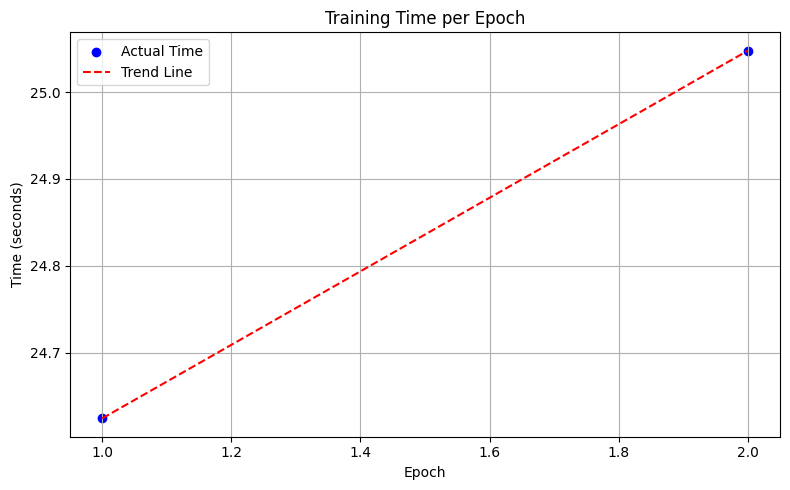

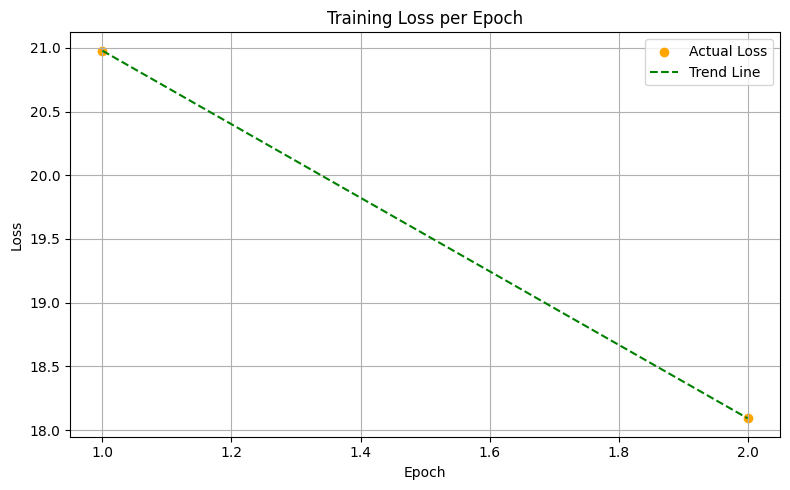

'Train BERT model on 1GB dataset'

In [ ]:
training_times_for_bert_models = []  # List to store training times for each BERT model

"""Train BERT model on 1MB dataset"""
bert_1MB, tokenizer_1MB , training_times_for_1MB = train_bert_model("dataset_1MB.csv", "bert_1MB", batch_size = 128, epochs=2, use_curriculum=True)
training_times_for_bert_models.append(training_times_for_1MB)

"""Train BERT model on 10MB dataset"""
# bert_10MB, tokenizer_10MB , training_times_for_10MB = train_bert_model("dataset_10MB.csv", "bert_10MB",batch_size = 128, epochs=2, use_curriculum=True)
# training_times_for_bert_models.append(training_times_for_10MB)

"""Train BERT model on 100MB dataset"""
# bert_100MB, tokenizer_100MB , training_times_for_100MB = train_bert_model("dataset_100MB.csv", "bert_100MB",batch_size = 64, epochs= 1, use_curriculum=True)
# training_times_for_bert_models.append(training_times_for_100MB)

"""Train BERT model on 1GB dataset"""
# bert_1GB, tokenizer_1GB , training_times_for_1GB = train_bert_model("dataset_1GB.csv", "bert_1GB",batch_size = 64, epochs = 1, use_curriculum=True)
# training_times_for_bert_models.append(training_times_for_1GB)



Below cell contains the function for testing a trained model with a testing data set. returns the results and metrics regarding the testing results

In [ ]:
def test_bert_model(model, tokenizer, csv_file="dataset_test_1MB.csv", batch_size=64):
    """
    Parameters:
        model: torch.nn.Module - Trained BERT model to evaluate.
        tokenizer: BertTokenizer - Tokenizer used to process the input text.
        csv_file: str - Path to the test dataset CSV file (default: 'dataset_test_1MB.csv').
        batch_size: int - Number of samples per batch during evaluation (default: 64).

    Function that evaluates a trained BERT model on a test dataset by running inference, collecting predictions,
    and computing evaluation metrics including accuracy,micro/macro precision, recall, F1-score, and confusion matrix.

    Returns:
        metrics: dict - Evaluation metrics.
        all_predictions: list[int] - Model predictions.
        all_labels: list[int] - Ground truth labels.
    """
    print(f"Testing model on {csv_file}...\n")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available
    model.to(device)      # Move model to device
    model.eval()          # Set model to evaluation mode

    df_test = pd.read_csv(csv_file)  # Load test data from CSV


    test_dataset = YelpDataset(df_test["text"].tolist(), df_test["stars"].tolist(), tokenizer) # Create test dataset by passing the text, labels, and tokenizer to the YelpDataset class
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)     # Create DataLoader to batch and iterate over the test dataset (no shuffling for evaluation)

    all_predictions = []  # Store predicted labels
    all_labels = []       # Store true labels

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)            # Move input_ids to device
            attention_mask = batch["attention_mask"].to(device)  # Move attention_mask to device
            labels = batch["labels"].to(device)                  # Move labels to device

            with autocast(device_type="cuda"):  # Use mixed precision for faster inference (on GPU)
                outputs = model(input_ids, attention_mask=attention_mask)  # Get model predictions

            predictions = torch.argmax(outputs.logits, dim=1)  # Get the predicted class

            all_predictions.extend(predictions.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())            # Store true labels

    metrics = compute_micro_macro_metrics(np.array(all_labels), np.array(all_predictions))  # Compute evaluation metrics

    print(f"\nEvaluation Metrics on {csv_file}:")
    for key, value in metrics.items():  # Print each metric
        if isinstance(value, (float, int)):
            print(f"{key}: {value:.4f}")  # Format numbers
        else:
            print(f"{key}:\n{value}")     # Print matrix

    return metrics, all_predictions, all_labels  # Return metrics and raw outputs

Below cell contains the testing of models on datasets as well as saving the results and metrics of the models tested

In [ ]:
metrics_for_bert_models = [] # Stores evaluation metrics for each model
y_trues_and_preds_for_bert_models = []  # Stores true and predicted labels for each model

"""Test the BERT model trained on 1MB dataset"""
metrics_1MB, y_pred_1MB, y_true_1MB = test_bert_model(bert_1MB, tokenizer_1MB, csv_file="dataset_test_1MB.csv")
metrics_for_bert_models.append(metrics_1MB)
y_trues_and_preds_for_bert_models.append((y_true_1MB, y_pred_1MB))

"""Test the BERT model trained on 10MB dataset"""
# metrics_10MB, y_pred_10MB, y_true_10MB = test_bert_model(bert_10MB, tokenizer_10MB, csv_file="dataset_test_1MB.csv")
# metrics_for_bert_models.append(metrics_10MB)
# y_trues_and_preds_for_bert_models.append((y_true_10MB, y_pred_10MB))

"""Test the BERT model trained on 100MB dataset"""
# metrics_100MB, y_pred_100MB, y_true_100MB = test_bert_model(bert_100MB, tokenizer_100MB, csv_file="dataset_test_1MB.csv")
# metrics_for_bert_models.append(metrics_100MB)
# y_trues_and_preds_for_bert_models.append((y_true_100MB, y_pred_100MB))

"""Test the BERT model trained on 1GB dataset"""
# metrics_1GB, y_pred_1GB, y_true_1GB = test_bert_model(bert_1GB, tokenizer_1GB, csv_file="dataset_test_1MB.csv")
# metrics_for_bert_models.append(metrics_1GB)
# y_trues_and_preds_for_bert_models.append((y_true_1GB, y_pred_1GB))


# save models

torch.save(bert_1MB.state_dict(), 'bert_1MB.pth')
torch.save(tokenizer_1MB, 'tokenizer_1MB.pth')

# torch.save(bert_10MB.state_dict(), 'bert_10MB.pth')
# torch.save(tokenizer_10MB, 'tokenizer_10MB.pth')

# torch.save(bert_100MB.state_dict(), 'bert_100MB.pth')
# torch.save(tokenizer_100MB, 'tokenizer_100MB.pth')

# torch.save(bert_1GB.state_dict(), 'bert_1GB.pth')
# torch.save(tokenizer_1GB, 'tokenizer_1GB.pth')


Testing model on dataset_test_1MB.csv...



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics on dataset_test_1MB.csv:
Accuracy: 0.5618
Confusion Matrix:
[[213   0   0   0  44]
 [106   0   0   0  34]
 [ 80   0   0   1 111]
 [ 53   0   0   0 352]
 [ 45   0   0   0 846]]
Micro Precision: 0.5618
Micro Recall: 0.5618
Micro F1-Score: 0.5618
Macro Precision: 0.2077
Macro Recall: 0.3557
Macro F1-Score: 0.2615


Below cell contains the function base line model (sklearn), function that trains on the same dataset based on previosuly trained BERT models. Uses a TF-IDF vecotorizationm and a logisitc regrtession for classigicaion

In [ ]:
def train_sklearn_model(csv_file, model_name, use_curriculum=False, max_rows=None):
    """
    Parameters:
        csv_file: str - Path to the CSV file containing the training data.
        model_name: str - Name under which to save the trained model and vectorizer.
        use_curriculum: bool - Whether to sort the data from easy to hard using curriculum learning.
        max_rows: int - Limit on number of rows used for training (optional; simulates file size constraints).

    Function that trains a scikit-learn text classification model using TF-IDF vectorization  and Logistic Regression.
    Can applie curriculum learning and row limits. Saves both the trained model and the vectorizer.

    Returns:
        model: sklearn.linear_model.LogisticRegression - Trained classification model.
        vectorizer: TfidfVectorizer - TF-IDF vectorizer used for feature extraction.
        training_time: float - Time (in seconds) taken to train the model.
    """

    print(f"\n Training sklearn model on {csv_file}...")
    df = pd.read_csv(csv_file)  # Load data from CSV

    df["stars"] = df["stars"] - 1  # Normalize star ratings from 1–5 to 0–4 for model compatibility

    if use_curriculum:
        df = apply_curriculum_learning(df)  # Sort by readability score easy to hard
    else:
        df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset randomly

    if max_rows:
        df = df.iloc[:max_rows]  # Limit data to simulate file size

    texts = df["text"].tolist()   # Extract review texts
    labels = df["stars"].tolist() # Extract target labels

    # Vectorize text using TF-IDF (limit to top 5000 features and remove English functionwords)
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(texts)  # Transform text into feature vectors
    y = np.array(labels)  # Convert labels to numpy array

    startime = time.perf_counter()  # Start timing training

    # Train a Logistic Regression classifier
    model = LogisticRegression(max_iter=200)
    model.fit(X, y)  # Fit model to data

    endtime = time.perf_counter()  # End timing
    trainning_time = endtime - startime  # Calculate total training time
    print(f"   Time for training: {trainning_time:.2f} seconds")

    # Save model and vectorizer
    joblib.dump(model, f"{model_name}_model.pkl")         # Save trained model
    joblib.dump(vectorizer, f"{model_name}_vectorizer.pkl")  # Save TF-IDF vectorizer
    print(f" Saved model and vectorizer as {model_name}_*.pkl")

    return model, vectorizer, trainning_time  # Return objects and training time

Function that tests the trained baseline model on the same testing dataset as the BERT model. returns the accuracus and metrics of the baseline model

In [ ]:
def test_sklearn_model(csv_file, model_name):
    """
    Parameters:
        csv_file: str - Path to the CSV file containing the test data.
        model_name: str - Prefix of the saved model and vectorizer file names (expects *_model.pkl and *_vectorizer.pkl).

    Function that loads a trained scikit-learn model and vectorizer, transforms the test data using
    TF-IDF, makes predictions, and computes evaluation metrics using the true and predicted labels.

    Returns:
        metrics: dict - Evaluation metrics including accuracy, precision, recall, F1-score, and confusion matrix.
        y_pred: list[int] - Predicted class labels.
        y_true: list[int] - Ground truth class labels.
    """


    # Load trained model and vectorizer
    model = joblib.load(f"{model_name}_model.pkl")
    vectorizer = joblib.load(f"{model_name}_vectorizer.pkl")

    df = pd.read_csv(csv_file)     # Load test data
    df["stars"] = df["stars"] - 1  # Shift star ratings from 1–5 to 0–4

    texts = df["text"].tolist()      # Extract review texts
    y_true = df["stars"].tolist()    # Extract true labels

    X = vectorizer.transform(texts)   # Transform text using the same TF-IDF vectorizer used during training
    y_pred = model.predict(X)  # Predict using the loaded model

    metrics = compute_micro_macro_metrics(y_true, y_pred)    # Compute performance metrics

    # Print evaluation results
    print(f"\n Metrics for {model_name} on test set {csv_file}:")
    for key, value in metrics.items():
        if isinstance(value, (float, int)):
            print(f"{key}: {value:.4f}")  # Print metric
        else:
            print(f"{key}:\n{value}")     # Print non-numeric metrics

    return metrics, y_pred, y_true  # Return metrics and predictions

Below cell is used for enabling what baseline model to train to use for comparing against BERT model. Each model is trained on same dataset as BERT model is trained on. uncomment desired baseline model to use

In [ ]:
traing_times_for_sklearn_models = []  # Stores training times for each scikit-learn model

"""Train sklearn model on 1MB dataset"""
base_line_model_1mb, baseline_vectorizer_1mb, trainng_time_sk_1MB = train_sklearn_model("dataset_1MB.csv", "sklearn_1mb", use_curriculum=True)
traing_times_for_sklearn_models.append(trainng_time_sk_1MB)

"""Train sklearn model on 10MB dataset"""
# base_line_model_10mb, baseline_vectorizer_10mb, trainng_time_sk_10MB = train_sklearn_model("dataset_10MB.csv", "sklearn_10mb", use_curriculum=True)
# traing_times_for_sklearn_models.append(trainng_time_sk_10MB)

"""Train sklearn model on 100MB dataset"""
# base_line_model_100mb, baseline_vectorizer_100mb, trainng_time_sk_100MB = train_sklearn_model("dataset_100MB.csv", "sklearn_100mb", use_curriculum=True)
# traing_times_for_sklearn_models.append(trainng_time_sk_100MB)

"""Train sklearn model on 1GB dataset"""
# base_line_model_1gb, baseline_vectorizer_1gb, trainng_time_sk_1GB = train_sklearn_model("dataset_1GB.csv", "sklearn_1gb", use_curriculum=True)
# traing_times_for_sklearn_models.append(trainng_time_sk_1GB)



 Training sklearn model on dataset_1MB.csv...
   Time for training: 1.49 seconds
 Saved model and vectorizer as sklearn_1mb_*.pkl


'Train sklearn model on 1GB dataset'

Below cell is used for enabling what baseline model to test to use for comparing against BERT model. Each model is tested on same dataset as BERT model is trained on. Saves the metrics and results of the tested baseline model uncomment desired baseline model to use

In [ ]:
metrics_for_sklearn_models = [] # Stores evaluation metrics for each sklearn model
y_trues_and_preds_for_sklearn_models = [] # Stores true and predicted labels for each sklearn model

"""Test sklearn model trained on 1MB dataset"""
metrics_for_sklearn_model_with_1MB_df, y_pred_sk_1MB,y_true_sk_1MB= test_sklearn_model("dataset_test_1MB.csv", "sklearn_1mb")
metrics_for_sklearn_models.append(metrics_for_sklearn_model_with_1MB_df)
y_trues_and_preds_for_sklearn_models.append((y_true_sk_1MB, y_pred_sk_1MB))

"""Test sklearn model trained on 10MB dataset"""
# metrics_for_sklearn_model_with_10MB_df, y_pred_sk_10MB,y_true_sk_10MB= test_sklearn_model("dataset_test_1MB.csv", "sklearn_10mb")
# metrics_for_sklearn_models.append(metrics_for_sklearn_model_with_10MB_df)
# y_trues_and_preds_for_sklearn_models.append((y_true_sk_10MB, y_pred_sk_10MB))

"""Test sklearn model trained on 100MB dataset"""
# metrics_for_sklearn_model_with_100MB_df, y_pred_sk_100MB,y_true_sk_100MB= test_sklearn_model("dataset_test_1MB.csv", "sklearn_100mb")
# metrcis_for_sklearn_models.append(metrics_for_sklearn_model_with_100MB_df)
# y_trues_and_preds_for_sklearn_models.append((y_true_sk_100MB, y_pred_sk_100MB))

"""Test sklearn model trained on 1GB dataset"""
# metrics_for_sklearn_model_with_1GB_df, y_pred_sk_1GB,y_true_sk_1GB= test_sklearn_model("dataset_test_1MB.csv", "sklearn_1gb")
# metrcis_for_sklearn_models.append(metrics_for_sklearn_model_with_1GB_df)
# y_trues_and_preds_for_sklearn_models.append((y_true_sk_1GB, y_pred_sk_1GB))


 Metrics for sklearn_1mb on test set dataset_test_1MB.csv:
Accuracy: 0.5883
Confusion Matrix:
[[169   2   1  10  75]
 [ 40   0  10  16  74]
 [ 19   2  10  52 109]
 [  4   0   4  79 318]
 [  6   0   2  32 851]]
Micro Precision: 0.5883
Micro Recall: 0.5883
Micro F1-Score: 0.5883
Macro Precision: 0.4190
Macro Recall: 0.3720
Macro F1-Score: 0.3549


'Test sklearn model trained on 1GB dataset'

Below cell is used for visutaling the metrics and results of both the BERT model and baseline model. used for comparions. produces differnt graphs and results for each model dataset size

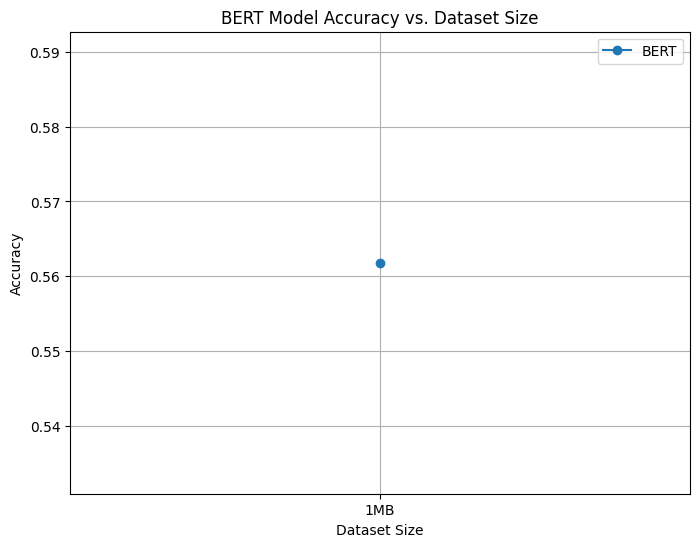

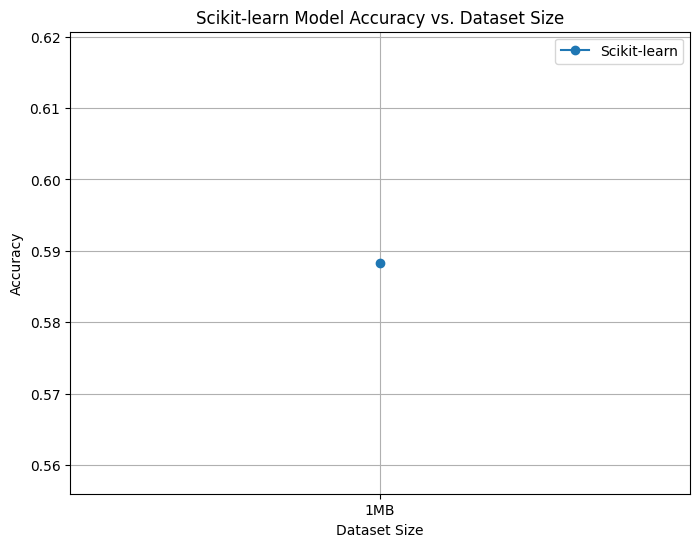

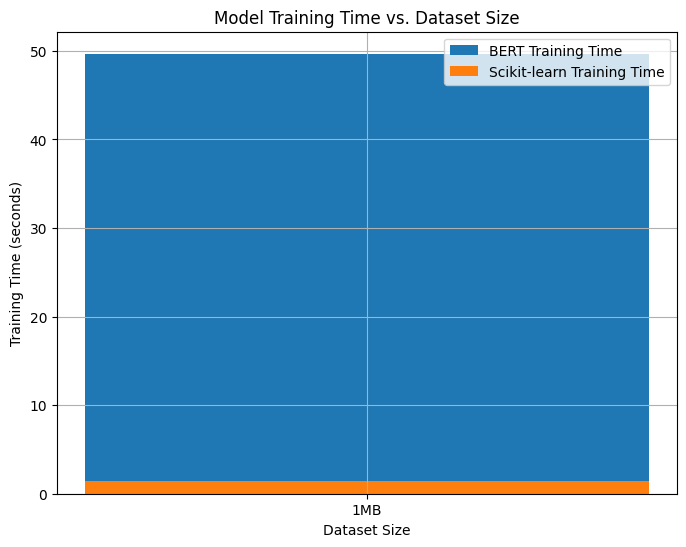

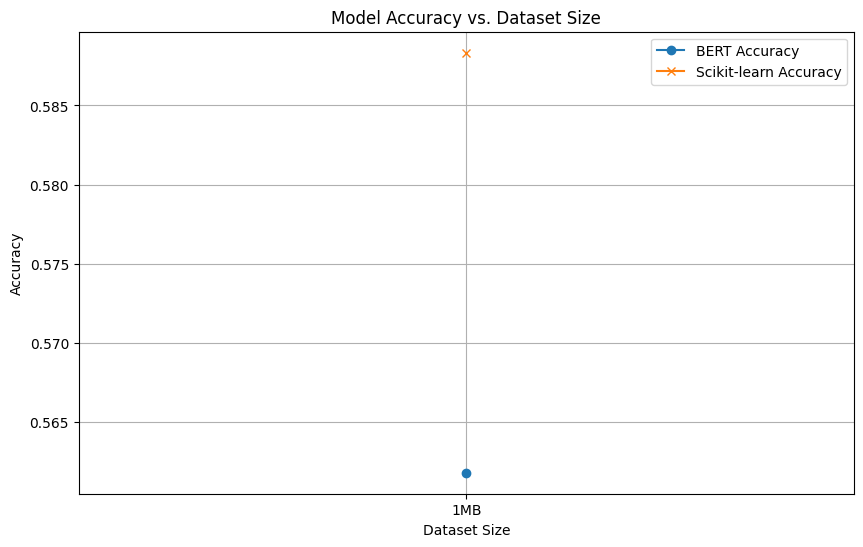

In [ ]:
dataset_sizes = [f"{10**i}MB" for i in range(len(metrics_for_bert_models))]  # Generate dataset size labels

# Accuracy Extraction
bert_accuracies = []  # Initialize list to store BERT model accuracies
for metrics in metrics_for_bert_models:
    bert_accuracies.append(metrics["Accuracy"])  # Append accuracy from each BERT model's metrics

sklearn_accuracies = []  # Initialize list to store sklearn model accuracies
for metrics in metrics_for_sklearn_models:
    sklearn_accuracies.append(metrics["Accuracy"])  # Append accuracy from each sklearn model's metrics

# Training Time Summation for BERT model
traing_times_for_bert_models = []  # Initialize list for total BERT training times
for times in training_times_for_bert_models:
    traing_times_for_bert_models.append(sum(times))  # Sum all epoch times for each BERT model

# Align all metrics and times to match available dataset sizes
bert_accuracies = [m["Accuracy"] for m in metrics_for_bert_models[:len(dataset_sizes)]]  # Slice to match dataset_sizes length
sklearn_accuracies = [m["Accuracy"] for m in metrics_for_sklearn_models[:len(dataset_sizes)]]  # Slice to match dataset_sizes length
traing_times_for_bert_plot = [sum(t) for t in training_times_for_bert_models[:len(dataset_sizes)]]  # Total BERT training time per dataset
traing_times_for_sklearn_plot = traing_times_for_sklearn_models[:len(dataset_sizes)]  # Slice sklearn training times

# Plot: BERT Accuracy vs. Dataset Size
plt.figure(figsize=(8, 6))  # Create a new figure with specified size
plt.plot(dataset_sizes, bert_accuracies, marker='o', label='BERT')  # Plot BERT accuracies vs dataset sizes
plt.xlabel('Dataset Size')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.title('BERT Model Accuracy vs. Dataset Size')  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Enable grid
plt.show()  # Display plot

#  Plot: Scikit-learn Accuracy vs. Dataset Size
plt.figure(figsize=(8, 6))  # Create a new figure
plt.plot(dataset_sizes, sklearn_accuracies, marker='o', label='Scikit-learn')  # Plot sklearn accuracies
plt.xlabel('Dataset Size')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.title('Scikit-learn Model Accuracy vs. Dataset Size')  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Enable grid
plt.show()  # Display plot

# Bar Chart: Training Time Comparison
plt.figure(figsize=(8, 6))  # Create a new figure
plt.bar(dataset_sizes, traing_times_for_bert_models, label='BERT Training Time')  # Bar chart for BERT training times
plt.bar(dataset_sizes, traing_times_for_sklearn_models, label='Scikit-learn Training Time')  # Bar chart for sklearn training times
plt.xlabel('Dataset Size')  # X-axis label
plt.ylabel('Training Time (seconds)')  # Y-axis label
plt.title('Model Training Time vs. Dataset Size')  # Plot title
plt.grid(True)  # Enable grid
plt.legend()  # Show legend
plt.show()  # Display plot

# Combined Line Plot: Accuracy Comparison
plt.figure(figsize=(10, 6))  # Create a new figure with larger width
plt.plot(dataset_sizes, bert_accuracies, marker='o', label='BERT Accuracy')  # Line for BERT accuracy
plt.plot(dataset_sizes, sklearn_accuracies, marker='x', label='Scikit-learn Accuracy')  # Line for sklearn accuracy
plt.xlabel('Dataset Size')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.title('Model Accuracy vs. Dataset Size')  # Plot title
plt.legend()  # Show legend
plt.grid(True)  # Enable grid
plt.show()  # Display plot


Below Cell contians function for plotting bar grpahs and confusion matrices for tested models

In [ ]:
def plot_classification_metrics(y_true, y_pred, class_labels):
    """
    Parameters:
        y_true: list[int] - Ground truth class labels.
        y_pred: list[int] - Predicted class labels.
        class_labels: list[str] - List of class label names for plotting.

    Function that computes and plots precision, recall, and F1-score for each class as a grouped bar chart.

    Returns:
        None
    """
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=range(len(class_labels)))  # Compute metrics
    x = np.arange(len(class_labels))  # X-axis positions for bars
    width = 0.25  # Width of each bar group

    plt.figure(figsize=(12, 6))  # Set figure size
    plt.bar(x - width, precision, width, label='Precision')  # Bar for precision
    plt.bar(x, recall, width, label='Recall')  # Bar for recall
    plt.bar(x + width, f1, width, label='F1 Score')  # Bar for F1

    plt.xticks(x, class_labels)  # Set x-axis tick labels
    plt.ylim(0, 1)  # Limit y-axis range from 0 to 1
    plt.title("Per-Class Metrics")  # Set plot title
    plt.ylabel("Score")  # Y-axis label
    plt.legend()  # Show legend
    plt.tight_layout()  # Fix spacing
    plt.show()  # Display plot

def plot_normalized_confusion_matrix(y_true, y_pred, class_labels):
    """
    Parameters:
        y_true: list[int] - Ground truth class labels.
        y_pred: list[int] - Predicted class labels.
        class_labels: list[str] - List of class label names.

    Function that plots a normalized confusion matrix as a heatmap using sklearn’s display utility.

    Returns:
        None
    """
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # Compute normalized confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)  # Create display object
    fig, ax = plt.subplots(figsize=(8, 6))  # Set up figure and axes
    disp.plot(ax=ax, cmap="YlGnBu", values_format=".2f")  # Plot heatmap with formatting
    plt.title("Normalized Confusion Matrix")  # Title
    plt.show()  # Show plot

def plot_prediction_distribution(y_true, y_pred, class_labels):
    """
    Parameters:
        y_true: list[int] - Ground truth class labels.
        y_pred: list[int] - Predicted class labels.
        class_labels: list[str] - List of class label names.

    Function that compares class distribution between ground truth and predicted values.
    Also shows a raw confusion matrix as a heatmap.

    Returns:
        None
    """
    y_true = np.array(y_true)  # Convert to numpy array
    y_pred = np.array(y_pred)  # Convert to numpy array
    true_counts = Counter(y_true)  # Count occurrences of true labels
    pred_counts = Counter(y_pred)  # Count occurrences of predicted labels

    x = np.arange(len(class_labels))  # X-axis indices for each class
    true_vals = [true_counts.get(i, 0) for i in x]  # Get counts or 0
    pred_vals = [pred_counts.get(i, 0) for i in x]  # Get counts or 0

    width = 0.35  # Width of bars
    plt.figure(figsize=(10, 5))  # Set figure size
    plt.bar(x - width/2, true_vals, width, label='True Labels')  # Bar for true labels
    plt.bar(x + width/2, pred_vals, width, label='Predicted Labels')  # Bar for predicted labels
    plt.xticks(x, class_labels)  # Class labels
    plt.ylabel("Count")  # Y-axis label
    plt.title("True vs Predicted Class Distribution")  # Title
    plt.legend()  # Legend
    plt.tight_layout()  # Layout
    plt.show()  # Show plot

    # Raw Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)  # Compute raw confusion matrix
    plt.figure(figsize=(8, 6))  # Figure size
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)  # Heatmap
    plt.title("Confusion Matrix (Raw Counts)")  # Title
    plt.xlabel("Predicted")  # X-axis label
    plt.ylabel("Actual")  # Y-axis label
    plt.tight_layout()  # Layout
    plt.show()  # Show plot

def show_misclassified_samples(df, y_true, y_pred, class_labels, top_n=5):
    """
    Parameters:
        df: pd.DataFrame - DataFrame containing the text data.
        y_true: list[int] - Ground truth class labels.
        y_pred: list[int] - Predicted class labels.
        class_labels: list[str] - List of class label names.
        top_n: int - Number of top misclassified class pairs to show (default is 5).

    Function that finds and prints sample reviews from the most confused class pairs.

    Returns:
        None
    """
    df_errors = df.copy()  # Copy input DataFrame
    df_errors["true"] = y_true  # Add true label column
    df_errors["pred"] = y_pred  # Add predicted label column
    df_errors = df_errors[df_errors["true"] != df_errors["pred"]]  # Keep only misclassified rows

    if df_errors.empty:  # No misclassifications
        print(" No misclassified samples found.")
        return

    confusion_pairs = confusion_matrix(df_errors["true"], df_errors["pred"])  # Confusion matrix from misclassifications
    confusion_pairs[np.diag_indices_from(confusion_pairs)] = 0  # Remove diagonal (correct predictions)

    # Find top N most frequent misclassification pairs
    max_confusion_indices = np.unravel_index(
        np.argsort(confusion_pairs, axis=None)[-top_n:], confusion_pairs.shape
    )

    print("\n Top Misclassified Class Pairs:")
    for true_label, pred_label in zip(*max_confusion_indices[::-1]):  # Reverse for descending sort
        subset = df_errors[(df_errors["true"] == true_label) & (df_errors["pred"] == pred_label)]  # Subset for pair
        if subset.empty:
            continue  # Skip if no examples for this pair
        print(f"\nTrue: {class_labels[true_label]} | Predicted: {class_labels[pred_label]}")
        for _, row in subset.sample(n=min(3, len(subset)), random_state=42).iterrows():  # Show up to 3 samples
            print(f"  ↳ {row['text'][:150].strip()}...")  # Print a preview of the review


def plot_class_distribution(df, class_column="stars", title="Class Distribution"):
    """
    Parameters:
        df: pd.DataFrame - DataFrame containing class labels.
        class_column: str - Column name for class labels (default: 'stars').
        title: str - Title for the plot.

    Function that plots the class distribution in the dataset as a bar chart.

    Returns:
        None
    """
    plt.figure(figsize=(8, 5))  # Set figure size
    sns.countplot(x=class_column, data=df, order=sorted(df[class_column].unique()))  # Bar plot of class frequencies
    plt.title(title)  # Set plot title
    plt.xlabel("Star Rating")  # X-axis label
    plt.ylabel("Count")  # Y-axis label
    plt.xticks(ticks=range(5), labels=["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"])  # Set readable ticks
    plt.tight_layout()  # Fix layout
    plt.show()  # Display plot


Below cell runs the visualizations of the differnt models and there results for the confusion matrix and bar graph. For each model trained and tested, there is a confusion matrix and bar graph prdouced for it


📊 Visualizing Metrics for Dataset Index 0 (1MB or similar)...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


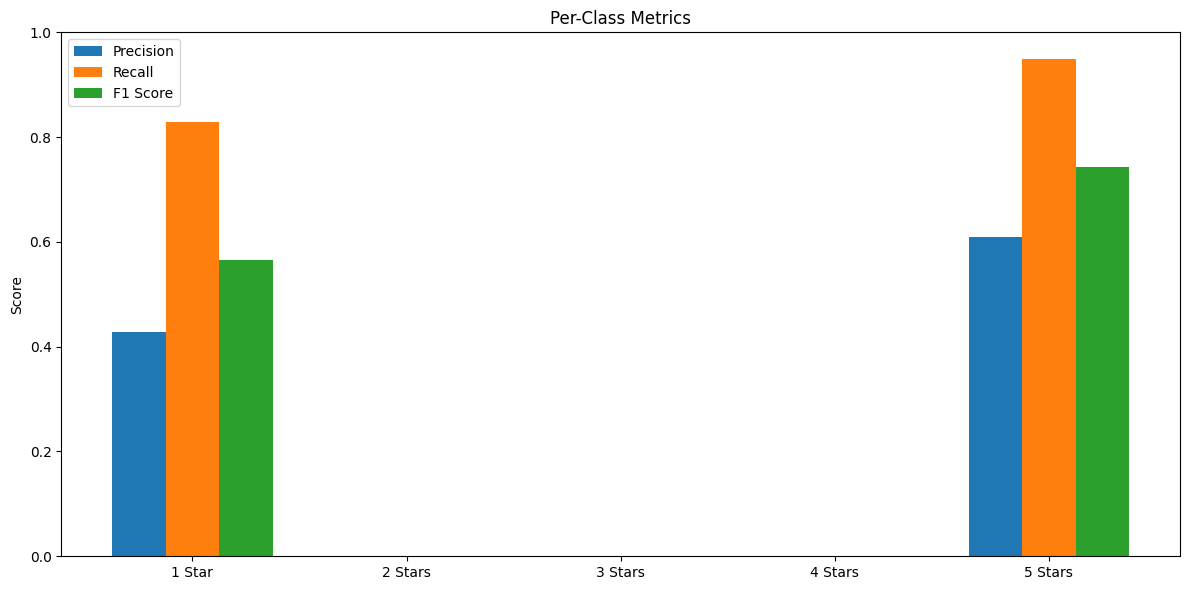

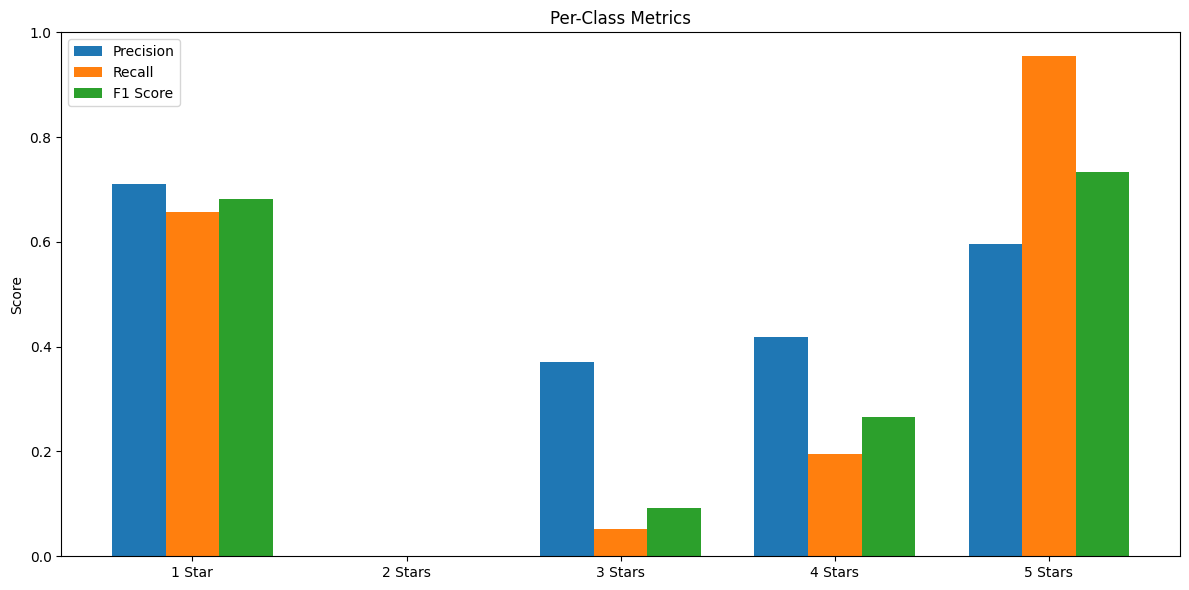

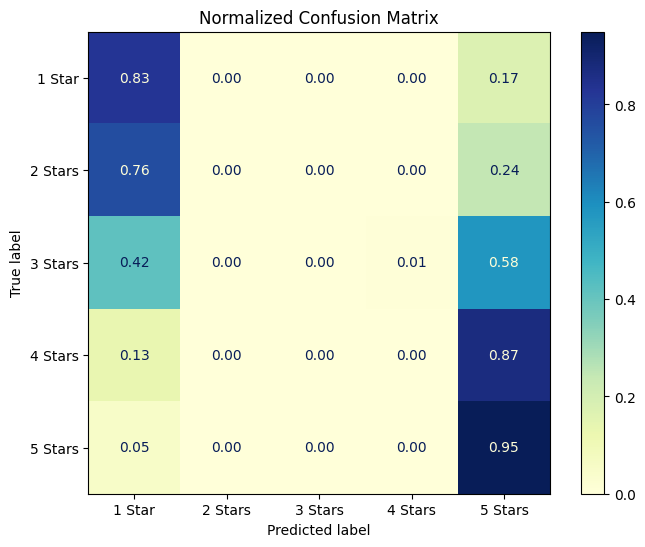

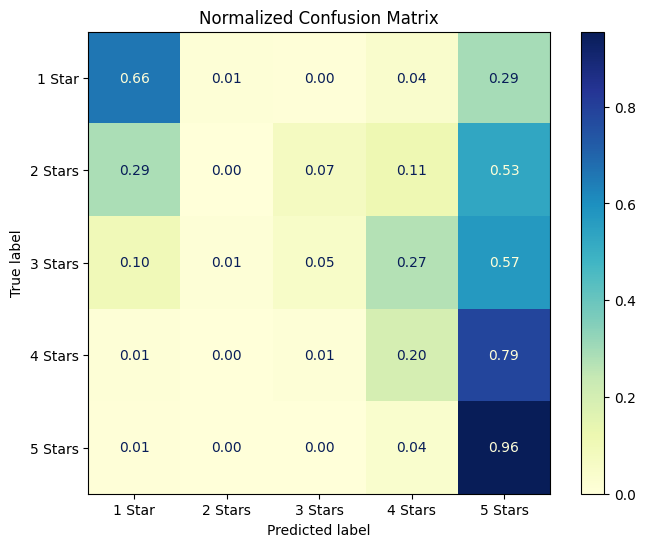

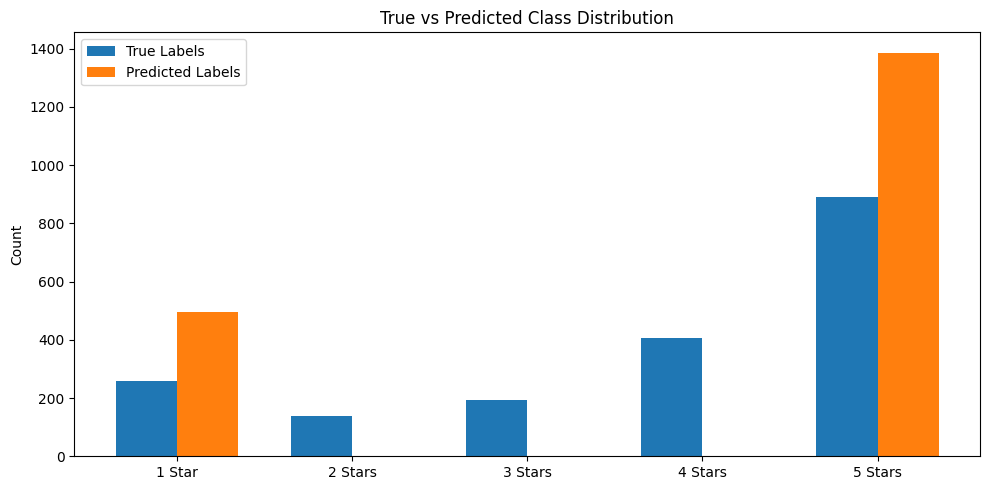

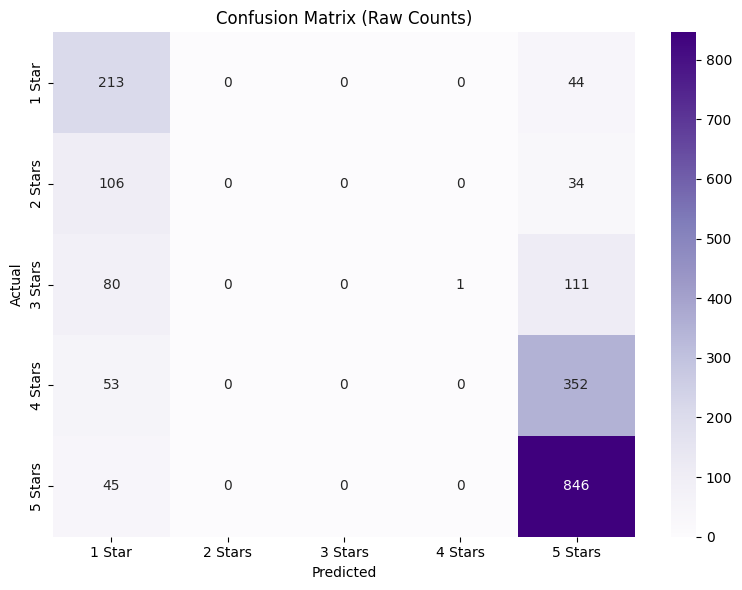

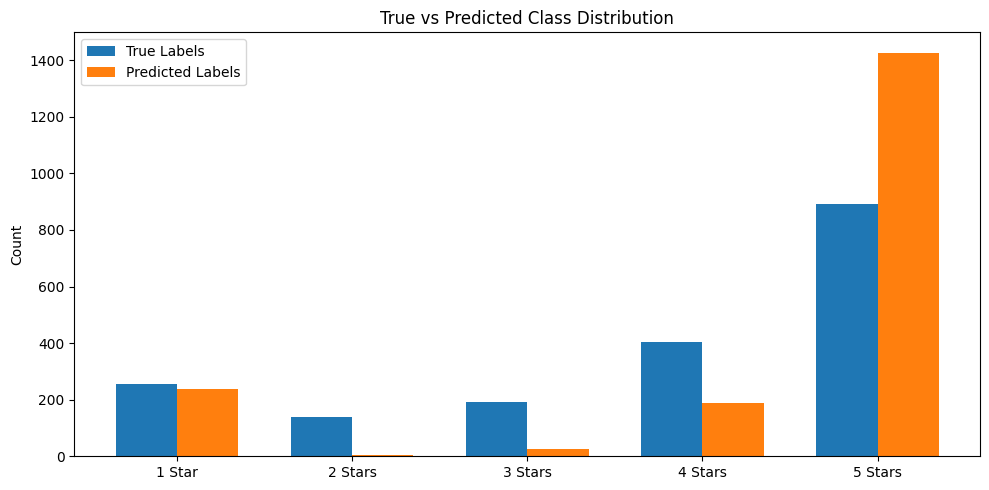

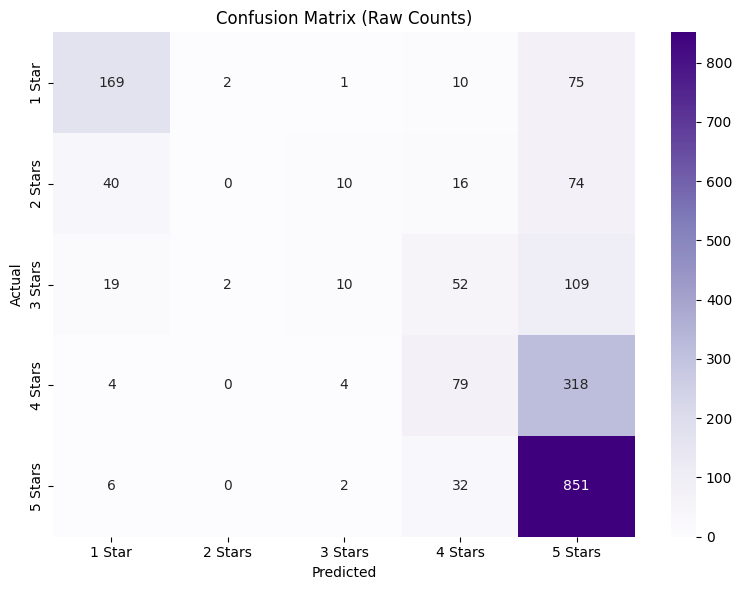


 Top Misclassified Class Pairs:

 Top Misclassified Class Pairs:

True: 4 Stars | Predicted: 3 Stars
  ↳ This place used to be AMAZING! Just got some breads to have but was very disappointed in the cheese steak! Steak was very chunky and little cheese sau...
  ↳ Not much interesting or exciting about this aquarium. Pretty standard stuff and their presentation was a bit sub par. We were hoping for much more....
  ↳ My boyfriend and I decided to stop in for a tasting right as it opened. The tasting room is inside a windmill - very cute! Our server was very nice an...

True: 5 Stars | Predicted: 1 Star
  ↳ Nauseatingly rude. They really put the "jerk" in Jamaican Jerk Hut. There's better food elsewhere anyway....
  ↳ We checked in late in the evening so as you can imagine, we were quite tired. Evening staff was great BUT daytime staff was a horror. That late evenin...
  ↳ Stopped by here while in town for Urbana in late December. My 3 friends and I were not disappointed! Burgers were fan

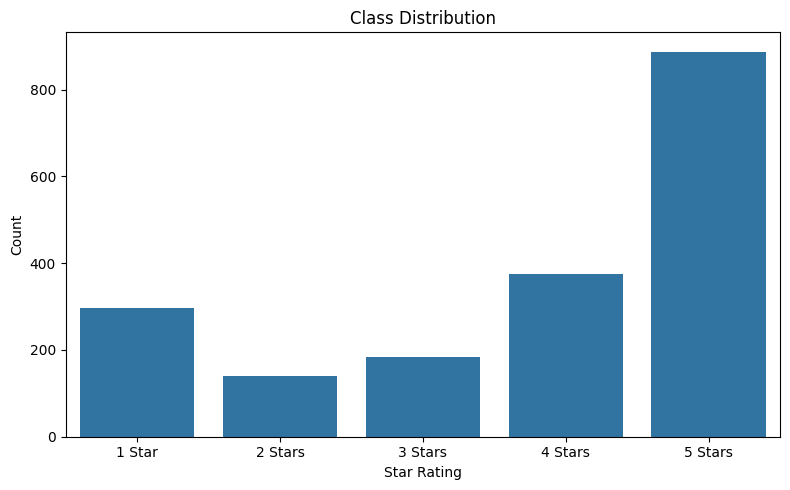

In [ ]:
for i in range(len(y_trues_and_preds_for_bert_models)):  # Loop through each dataset
    y_true_bert, y_pred_bert = y_trues_and_preds_for_bert_models[i]  # Get BERT's true and predicted labels
    y_true_sklearn, y_pred_sklearn = y_trues_and_preds_for_sklearn_models[i]  # Get sklearn's true and predicted labels
    class_labels = ["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]  # Define class label names for plots
    test_df = test_dfs_for_models[i]  # Get the corresponding test DataFrame for current dataset size

    print(f"\n📊 Visualizing Metrics for Dataset Index {i} ({10**i}MB or similar)...")  # Print current dataset index and size

    plot_classification_metrics(y_true_bert, y_pred_bert, class_labels)  # Plot BERT's precision, recall, and F1
    plot_classification_metrics(y_true_sklearn, y_pred_sklearn, class_labels)  # Plot sklearn's precision, recall, and F1

    plot_normalized_confusion_matrix(y_true_bert, y_pred_bert, class_labels)  # Plot BERT's normalized confusion matrix
    plot_normalized_confusion_matrix(y_true_sklearn, y_pred_sklearn, class_labels)  # Plot sklearn's normalized confusion matrix

    plot_prediction_distribution(y_true_bert, y_pred_bert, class_labels)  # Plot BERT's true vs predicted label distribution
    plot_prediction_distribution(y_true_sklearn, y_pred_sklearn, class_labels)  # Plot sklearn's true vs predicted label distribution

    trimmed_df_bert = test_df.iloc[:len(y_true_bert)].copy()  # Trim test DataFrame to match BERT prediction length
    trimmed_df_sklearn = test_df.iloc[:len(y_true_sklearn)].copy()  # Trim test DataFrame to match sklearn prediction length

    show_misclassified_samples(trimmed_df_bert, y_true_bert, y_pred_bert, class_labels)  # Display misclassified samples for BERT
    show_misclassified_samples(trimmed_df_sklearn, y_true_sklearn, y_pred_sklearn, class_labels)  # Display misclassified samples for sklearn

    plot_class_distribution(test_df)  # Plot the class distribution of the original test data



Below cell is used to test if the enviroment is functioning properly. if any error is found run the below cell. if it produces an error, go to runtime -> manage runtime logs -> terminate all sessions. refresh colab and make a new session and run this to confirm working. if the below cell does not return an error restart colab

In [ ]:
import os  # OS module for environment variable manipulation
import torch  # PyTorch library for tensor and model operations
from transformers import BertForSequenceClassification  # Import BERT model for classification

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Ensures synchronous CUDA error reporting for debugging

print(torch.cuda.is_available())  # Check if CUDA (GPU) is available; should print True if GPU is accessible

dummy = torch.tensor([1.0]).to("cuda")  # Send a dummy tensor to GPU to confirm CUDA is working
print("CUDA is working.")  # Print confirmation that CUDA is functioning

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)  # Load pretrained BERT classification model with 5 output classes
model = model.to("cuda")  # Move model to GPU (this line will crash if CUDA setup is broken)
print("Model moved to CUDA successfully.")  # Print confirmation that model


True
CUDA is working.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to CUDA successfully.


#Reference


PyTorch
Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... & Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. In Advances in Neural Information Processing Systems (NeurIPS).
URL: https://pytorch.org/


Transformers (Hugging Face)
Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., ... & Rush, A. M. (2020). Transformers: State-of-the-Art Natural Language Processing. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations.
URL: https://huggingface.co/transformers


BERT (Pretrained Model)
Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. In Proceedings of NAACL-HLT.
URL: https://arxiv.org/abs/1810.04805


TextStat
“Textstat.” PyPI, pypi.org/project/textstat/. Accessed 28 Mar. 2025.
URL: https://pypi.org/project/textstat/


NumPy
Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362.
URL: https://numpy.org/



scikit-learn
Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825–2830.
URL: https://scikit-learn.org/


Seaborn
Waskom, M. L. (2021). Seaborn: Statistical Data Visualization. Journal of Open Source Software, 6(60), 3021.
URL: https://seaborn.pydata.org/


Matplotlib
Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95.
URL: https://matplotlib.org/


Pandas
McKinney, W. (2010). Data Structures for Statistical Computing in Python. In Proceedings of the 9th Python in Science Conference, 51–56.
URL: https://pandas.pydata.org/


tqdm
Da Costa-Luis, C. (2019). tqdm: A Fast, Extensible Progress Bar for Python and CLI. Journal of Open Source Software, 4(37), 1277.
URL: https://github.com/tqdm/tqdm


gdown (for Google Drive downloads)
gdown: Download a large file from Google Drive. GitHub Repository.
URL: https://github.com/wkentaro/gdown
